## Import

In [1]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass

## Discipline

In [2]:
from gemseo.disciplines.auto_py import AutoPyDiscipline
discipline_aerodynamic = AutoPyDiscipline(aerodynamic)
discipline_approach = AutoPyDiscipline(approach)
discipline_battery = AutoPyDiscipline(battery)
discipline_climb = AutoPyDiscipline(climb)
discipline_engine = AutoPyDiscipline(engine)
discipline_fuel_tank = AutoPyDiscipline(fuel_tank)
discipline_geometry = AutoPyDiscipline(geometry)
discipline_mass = AutoPyDiscipline(mass)
discipline_mission = AutoPyDiscipline(mission)
discipline_operating_cost = AutoPyDiscipline(operating_cost)
discipline_take_off = AutoPyDiscipline(take_off)
discipline_total_mass = AutoPyDiscipline(total_mass)


In [3]:
disciplines = [discipline_aerodynamic,discipline_approach,discipline_battery,discipline_climb,discipline_engine,
               discipline_fuel_tank,discipline_geometry,discipline_mass,discipline_mission,discipline_operating_cost,
               discipline_take_off,discipline_total_mass]

## Uncertain Space

In [4]:
from gemseo_oad_training.unit import convert_from
from gemseo.scenarios.mdo_scenario import MDOScenario
from gemseo import configure_logger

configure_logger()


<RootLogger root (INFO)>

In [5]:
from gemseo.algos.parameter_space import ParameterSpace
from utils import update_default_inputs

x_def={'slst':convert_from('kN',150),'n_pax':150.0,'area':180.0,'ar':9.0,'fuel_type':'kerosene','engine_type':'turbofan','design_range':5500000}
update_default_inputs(disciplines,x_def)
uncertain_space = ParameterSpace()
uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1., maximum=1.03)



In [6]:
from gemseo import sample_disciplines
from gemseo.disciplines.surrogate import SurrogateDiscipline


In [7]:
training_dataset = sample_disciplines(disciplines, uncertain_space, ["tofl", "vapp","vz","span","length","fm","mtom"], algo_name="OT_MONTE_CARLO", n_samples=100)

    INFO - 16:48:26: *** Start Sampling execution ***
    INFO - 16:48:26: Sampling
    INFO - 16:48:26:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 16:48:26:    MDO formulation: MDF
    INFO - 16:48:26: Running the algorithm OT_MONTE_CARLO:
    INFO - 16:48:28:    100%|██████████| 100/100 [00:01<00:00, 54.48 it/sec]
    INFO - 16:48:28: *** End Sampling execution (time: 0:00:01.854097) ***


In [8]:
surrogate_discipline = SurrogateDiscipline("RBFRegressor", training_dataset)

In [9]:
r2 = surrogate_discipline.get_error_measure("R2Measure")
r2.compute_learning_measure(as_dict=True)


{'fm': array([1.]),
 'length': array([1.]),
 'mtom': array([1.]),
 'span': array([1.]),
 'tofl': array([1.]),
 'vapp': array([1.]),
 'vz': array([1.])}

In [10]:
r2.compute_cross_validation_measure(as_dict=True)


{'fm': array([0.99931487]),
 'length': array([nan]),
 'mtom': array([0.99913381]),
 'span': array([1.]),
 'tofl': array([0.99913216]),
 'vapp': array([0.99910602]),
 'vz': array([0.99941919])}

In [11]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_learning_measure(as_dict=True)


{'fm': array([7.02166694e-17]),
 'length': array([0.]),
 'mtom': array([0.]),
 'span': array([0.]),
 'tofl': array([0.]),
 'vapp': array([3.17764372e-15]),
 'vz': array([4.78298717e-16])}

In [12]:
rmse.compute_cross_validation_measure(as_dict=True)


{'fm': array([0.00049315]),
 'length': array([0.]),
 'mtom': array([9.69545555]),
 'span': array([0.]),
 'tofl': array([0.26671927]),
 'vapp': array([0.0041524]),
 'vz': array([0.00267169])}

In [13]:
from matplotlib import pyplot as plt

from gemseo import sample_disciplines
from gemseo.algos.parameter_space import ParameterSpace
from gemseo.disciplines.analytic import AnalyticDiscipline
from gemseo.uncertainty.statistics.empirical_statistics import EmpiricalStatistics

In [14]:
statistics = EmpiricalStatistics(training_dataset)
mean = statistics.compute_mean()
mean

{'aef': array([1.00788825]),
 'cef': array([1.00629333]),
 'fm': array([1.19169286]),
 'length': array([37.]),
 'mtom': array([75072.62669421]),
 'sef': array([1.00791544]),
 'span': array([40.24922359]),
 'tofl': array([1128.2551138]),
 'vapp': array([56.76798795]),
 'vz': array([7.34141378])}

In [15]:
variance = statistics.compute_variance()
variance

{'aef': array([7.37077678e-05]),
 'cef': array([8.44338002e-05]),
 'fm': array([0.00035496]),
 'length': array([0.]),
 'mtom': array([108523.81364031]),
 'sef': array([7.1277677e-05]),
 'span': array([5.04870979e-29]),
 'tofl': array([81.97279175]),
 'vapp': array([0.01928714]),
 'vz': array([0.01228967])}

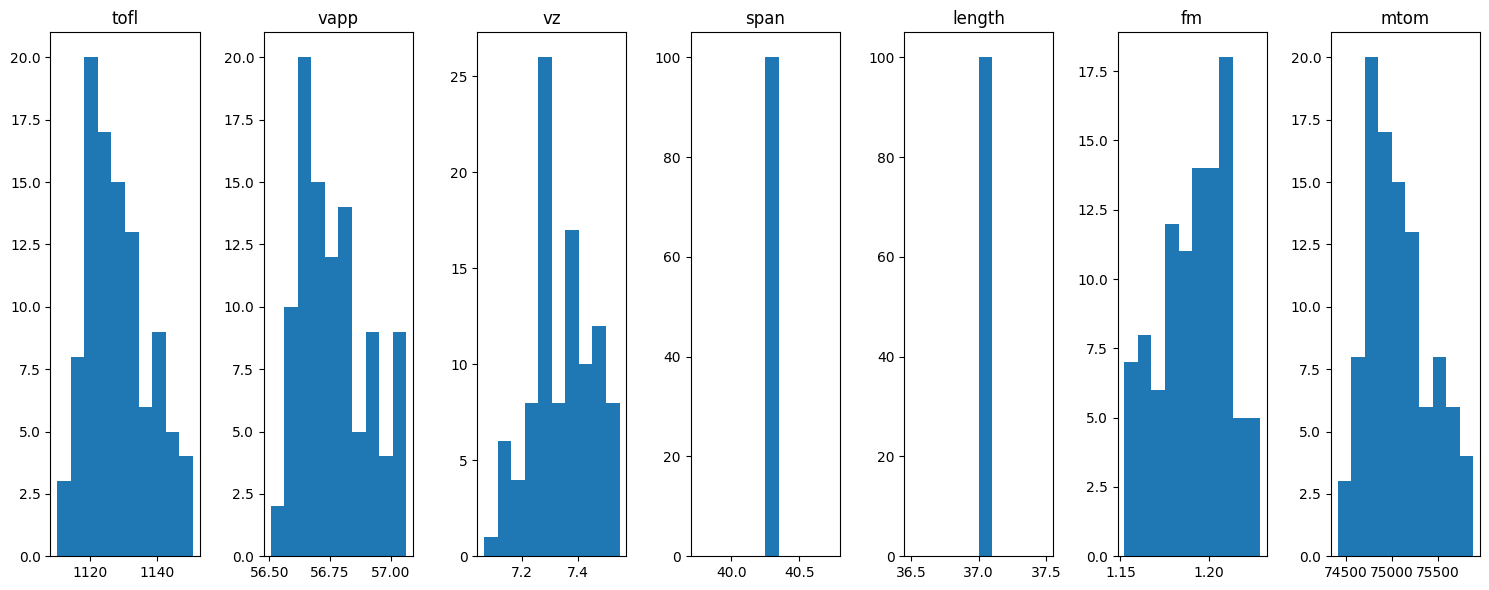

In [16]:
fig, axes = plt.subplots(1, 7,figsize=(15,6))
for ax, name in zip(axes, ["tofl", "vapp","vz","span","length","fm","mtom"]):
    ax.hist(training_dataset.get_view(variable_names=name))
    ax.set_title(name)
plt.tight_layout()
plt.show()

In [17]:
from gemseo.uncertainty.sensitivity.sobol_analysis import SobolAnalysis


In [18]:
sobol = SobolAnalysis()
sobol.compute_samples([surrogate_discipline], uncertain_space, 100)

 WARNING - 16:48:32: No coupling in MDA, switching chain_linearize to True.
    INFO - 16:48:32: *** Start SobolAnalysisSamplingPhase execution ***
    INFO - 16:48:32: SobolAnalysisSamplingPhase
    INFO - 16:48:32:    Disciplines: RBF_Sampling
    INFO - 16:48:32:    MDO formulation: MDF
    INFO - 16:48:32: Running the algorithm OT_SOBOL_INDICES:
    INFO - 16:48:33:    100%|██████████| 96/96 [00:01<00:00, 66.24 it/sec]
    INFO - 16:48:33: *** End SobolAnalysisSamplingPhase execution (time: 0:00:01.478094) ***


GROUP        inputs                       outputs                       \
VARIABLE        aef       cef       sef        fm length          mtom   
COMPONENT         0         0         0         0      0             0   
0          1.011287  1.018858  1.018127  1.162922   37.0  75638.370173   
1          0.996470  0.998531  0.994315  1.217367   37.0  74426.477987   
2          1.012159  1.000496  1.024286  1.198988   37.0  75644.870974   
3          0.999643  0.997105  0.997688  1.218157   37.0  74530.528937   
4          0.999603  1.028623  0.996241  1.158226   37.0  74870.256349   
..              ...       ...       ...       ...    ...           ...   
91         0.995934  0.999781  0.997909  1.216229   37.0  74553.499594   
92         1.016577  1.002006  1.006415  1.191473   37.0  75017.041617   
93         1.005482  0.997079  0.994671  1.211998   37.0  74455.491961   
94         1.021060  1.007666  1.003858  1.175851   37.0  75014.398714   
95         1.011845  1.020575  1.001509  1.159606   37.0  75024.811898   

GROUP                                                   
VARIABLE        span         tofl       vapp        vz  
COMPONENT          0            0          0         0  
0          40.249224  1143.829959  56.939029  7.168286  
1          40.249224  1110.566358  56.552324  7.585770  
2          40.249224  1144.006588  57.037418  7.161459  
3          40.249224  1113.404116  56.600029  7.539466  
4          40.249224  1122.690920  56.590348  7.446375  
..               ...          ...        ...       ...  
91         40.249224  1114.029764  56.605142  7.556266  
92         40.249224  1126.709408  56.743677  7.301023  
93         40.249224  1111.358879  56.551175  7.522752  
94         40.249224  1126.636861  56.701080  7.272764  
95         40.249224  1126.923187  56.661854  7.328571  

[96 rows x 10 columns]

In [19]:
sobol.compute_indices(output_names=["tofl", "vapp","vz","fm","mtom"])

SobolAnalysis.SensitivityIndices(first={'tofl': [{'aef': array([0.16245367]), 'cef': array([0.29557673]), 'sef': array([0.21235095])}], 'vapp': [{'aef': array([0.09793961]), 'cef': array([0.1086649]), 'sef': array([0.26467209])}], 'vz': [{'aef': array([0.42305365]), 'cef': array([0.40700897]), 'sef': array([0.10810095])}], 'fm': [{'aef': array([-0.2243325]), 'cef': array([0.99155831]), 'sef': array([-0.23803875])}], 'mtom': [{'aef': array([0.1628205]), 'cef': array([0.29674471]), 'sef': array([0.21358517])}]}, second={'tofl': [{'aef': {'aef': array([[0.]]), 'cef': array([[-0.35674742]]), 'sef': array([[-0.30578348]])}, 'cef': {'aef': array([[-0.35674742]]), 'cef': array([[0.]]), 'sef': array([[-0.40709945]])}, 'sef': {'aef': array([[-0.30578348]]), 'cef': array([[-0.40709945]]), 'sef': array([[0.]])}}], 'vapp': [{'aef': {'aef': array([[0.]]), 'cef': array([[-0.19487923]]), 'sef': array([[-0.19249028]])}, 'cef': {'aef': array([[-0.19487923]]), 'cef': array([[0.]]), 'sef': array([[-0.223

In [20]:
import pprint

In [21]:
pprint.pprint(sobol.indices.first)
pprint.pprint(sobol.indices.total)

{'fm': [{'aef': array([-0.2243325]),
         'cef': array([0.99155831]),
         'sef': array([-0.23803875])}],
 'mtom': [{'aef': array([0.1628205]),
           'cef': array([0.29674471]),
           'sef': array([0.21358517])}],
 'tofl': [{'aef': array([0.16245367]),
           'cef': array([0.29557673]),
           'sef': array([0.21235095])}],
 'vapp': [{'aef': array([0.09793961]),
           'cef': array([0.1086649]),
           'sef': array([0.26467209])}],
 'vz': [{'aef': array([0.42305365]),
         'cef': array([0.40700897]),
         'sef': array([0.10810095])}]}
{'fm': [{'aef': array([0.09066611]),
         'cef': array([1.17960091]),
         'sef': array([0.01312076])}],
 'mtom': [{'aef': array([-0.0220778]),
           'cef': array([0.07121632]),
           'sef': array([0.79228825])}],
 'tofl': [{'aef': array([-0.02265559]),
           'cef': array([0.07096713]),
           'sef': array([0.79349821])}],
 'vapp': [{'aef': array([0.00811674]),
           'cef': array([0.

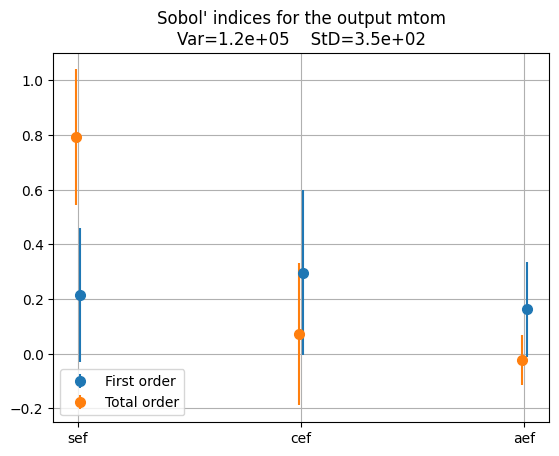

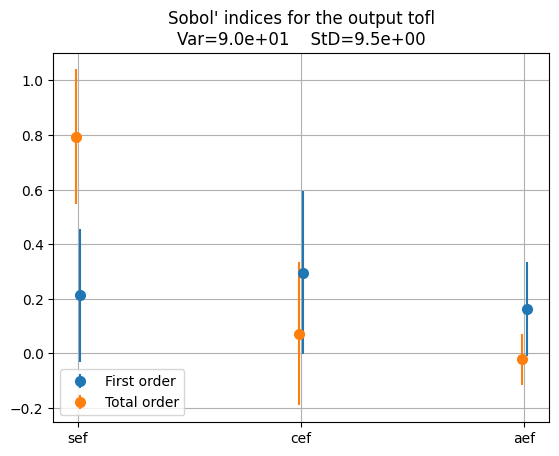

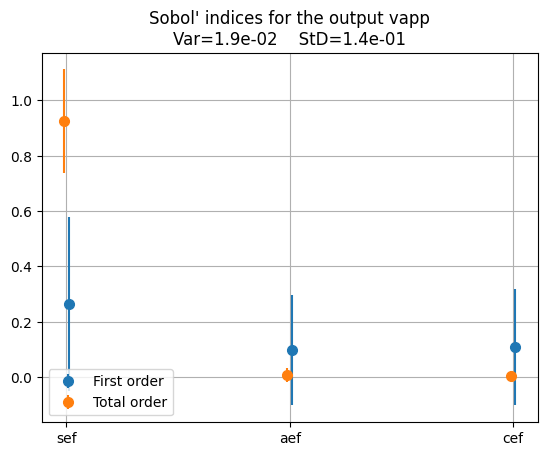

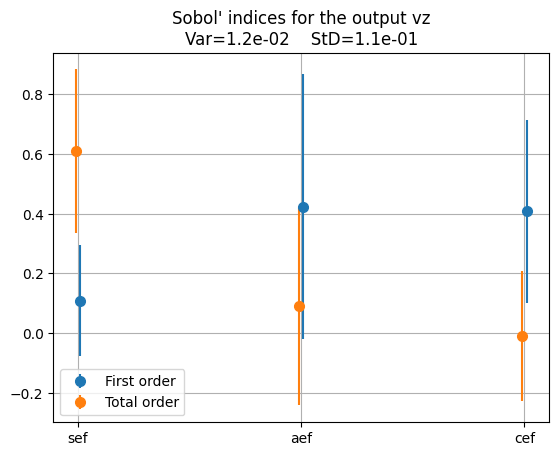

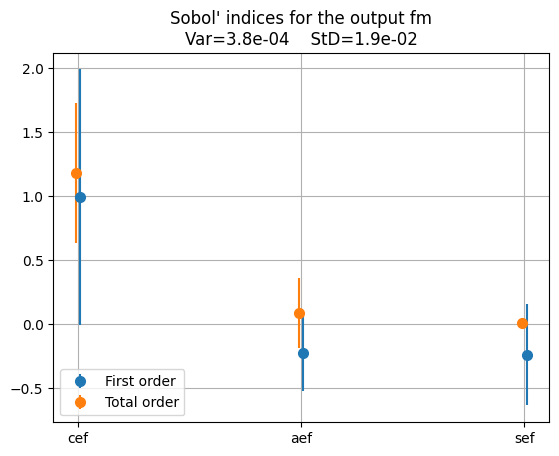

In [22]:
plt.show(sobol.plot("mtom", save=False, show=True))
plt.show(sobol.plot("tofl", save=False, show=True))
plt.show(sobol.plot("vapp", save=False, show=True))
plt.show(sobol.plot("vz", save=False, show=True))
plt.show(sobol.plot("fm", save=False, show=True))



